In [1]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as np
import numpy as onp
import os
import matplotlib.pyplot as plt
from discretization2D import *
from solver import *
from plot import *

os.environ["CUDA_VISIBLE_DEVICES"]="1"
jax.config.update("jax_enable_x64", True)
%matplotlib notebook

In [2]:
### 2D box mesh
domain_x = 1.
domain_y = 1.
Nx = 128
Ny = 128
cell_num = Nx*Ny
num_nodes = (Nx + 1) * (Ny + 1)
x = onp.linspace(0., domain_x, Nx + 1)
y = onp.linspace(0., domain_y, Ny + 1)
xx, yy = onp.meshgrid(x, y, indexing='ij')
points = onp.vstack([xx.reshape(-1), yy.reshape(-1)]).T

xc = np.array((xx[1:, 1:] + xx[:-1, 1:])/2)[:, :,None]
yc = np.array((yy[1:, 1:] + yy[1:, :-1])/2)[:, :,None]

dX = np.array([domain_x/Nx, domain_y/Ny])

### BC: -x,+x,-y,+y; 0 for dirichlet, 1 for neumann
BCs = [0,0,0,0]
v1 = np.array([0.,0.,])
v2 = np.array([1.,0.,])
values = [v1,v1,v1,v2]
BC_info = [BCs,values]

In [3]:
### example 1: transient solver, implicit 
def compute_residual(vel,p,vel0,vel0_f):
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    vel_b = get_bound_values(vel,BC_info,dX)
    
    res1 = ((vel-vel0)/dt*dX[0]*dX[1] + 
            convection(vel,vel_b,vel0_f,dX) - 
            diffusion(vel,vel_b,visco,dX) + 
            gradient(p,p_b,dX)*dX[0]*dX[1])
    
    u_f,v_f = get_face_values(vel,BC_info,dX)
    res2 = ((u_f[1:,:]-u_f[:-1,:])*dX[1] + (v_f[:,1:]-v_f[:,:-1])*dX[0])  
    
    return np.concatenate((res1.flatten(),res2.flatten()))

@jax.jit
def time_integration(vel0,vel0_f):
    def A_fn(f):
        vel = f[:Nx*Ny*2].reshape((Nx,Ny,-1))
        p = f[Nx*Ny*2:].reshape((Nx,Ny,-1))
        return compute_residual(vel,p,vel0,vel0_f)
    
    
    dofs = np.zeros(Nx*Ny*3)
    dofs,res = solver_linear(A_fn,dofs)
    
    vel0 = dofs[:Nx*Ny*2].reshape(Nx,Ny,-1)
    p = dofs[Nx*Ny*2:].reshape(Nx,Ny,-1)
    vel0_f = get_face_values(vel0,BC_info,dX)
    return vel0,vel0_f,p,res

In [6]:
%%time
#Re = 100
visco = 0.001
dt = 0.005
vel0 = np.zeros((Nx,Ny,2))
p0 = np.zeros((Nx,Ny,1))
vel0_f = get_face_values(vel0,BC_info,dX)
for i in range(0,5000):
    vel0,vel0_f,p0,res = time_integration(vel0,vel0_f)
    
    if res > 1e-5:
        print(f"res_norm = {res}, check the convergence!")
        break
        
    if i % 50 == 0:
        print(f"res_norm = {res}")

res_norm = 9.99595820075367e-06
res_norm = 9.415575107639947e-06
res_norm = 9.955380982778906e-06
res_norm = 5.115062780280452e-06
res_norm = 9.340645088611232e-06
res_norm = 9.759483593330976e-06
res_norm = 9.648422907788988e-06
res_norm = 9.85453281891688e-06
res_norm = 9.41939806702227e-06
res_norm = 9.018845212006618e-06
res_norm = 8.644244679682854e-06
res_norm = 9.751142628605397e-06
res_norm = 8.234667608872638e-06
res_norm = 9.919166956508996e-06
res_norm = 9.998842681833365e-06
res_norm = 9.80323103375834e-06
res_norm = 9.034189663886144e-06
res_norm = 9.756877169559474e-06
res_norm = 9.91303847603635e-06
res_norm = 9.83340564175719e-06
res_norm = 9.995130817938355e-06
res_norm = 9.992480204272627e-06
res_norm = 9.999194341612319e-06
res_norm = 9.994550241157105e-06
res_norm = 9.860658356374652e-06
res_norm = 9.9251563860328e-06
res_norm = 9.923446098936125e-06
res_norm = 9.999111254015009e-06
res_norm = 9.350265572233858e-06
res_norm = 9.998268774600942e-06
res_norm = 9.99215

<IPython.core.display.Javascript object>


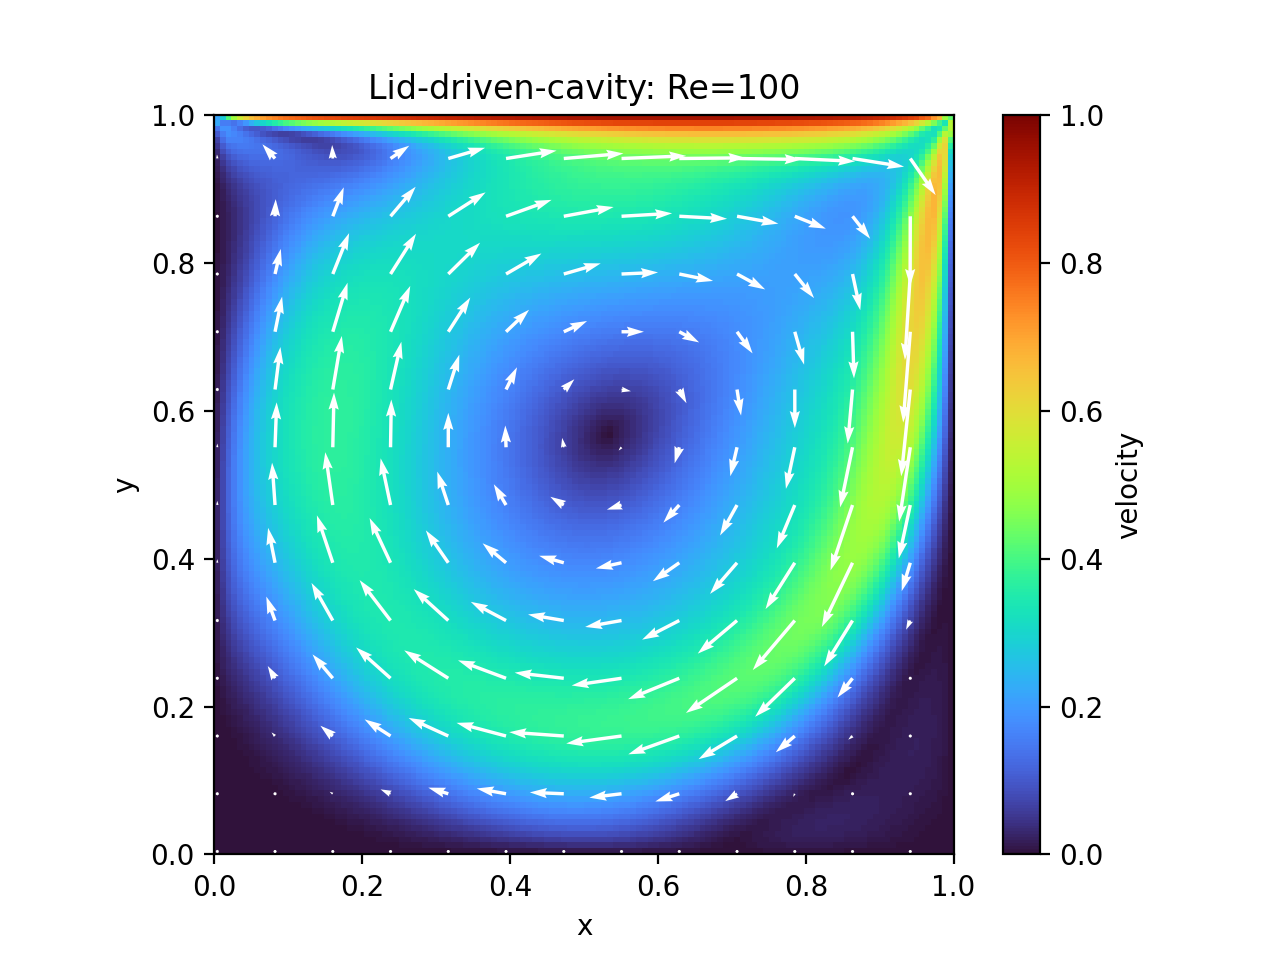

<IPython.core.display.Javascript object>


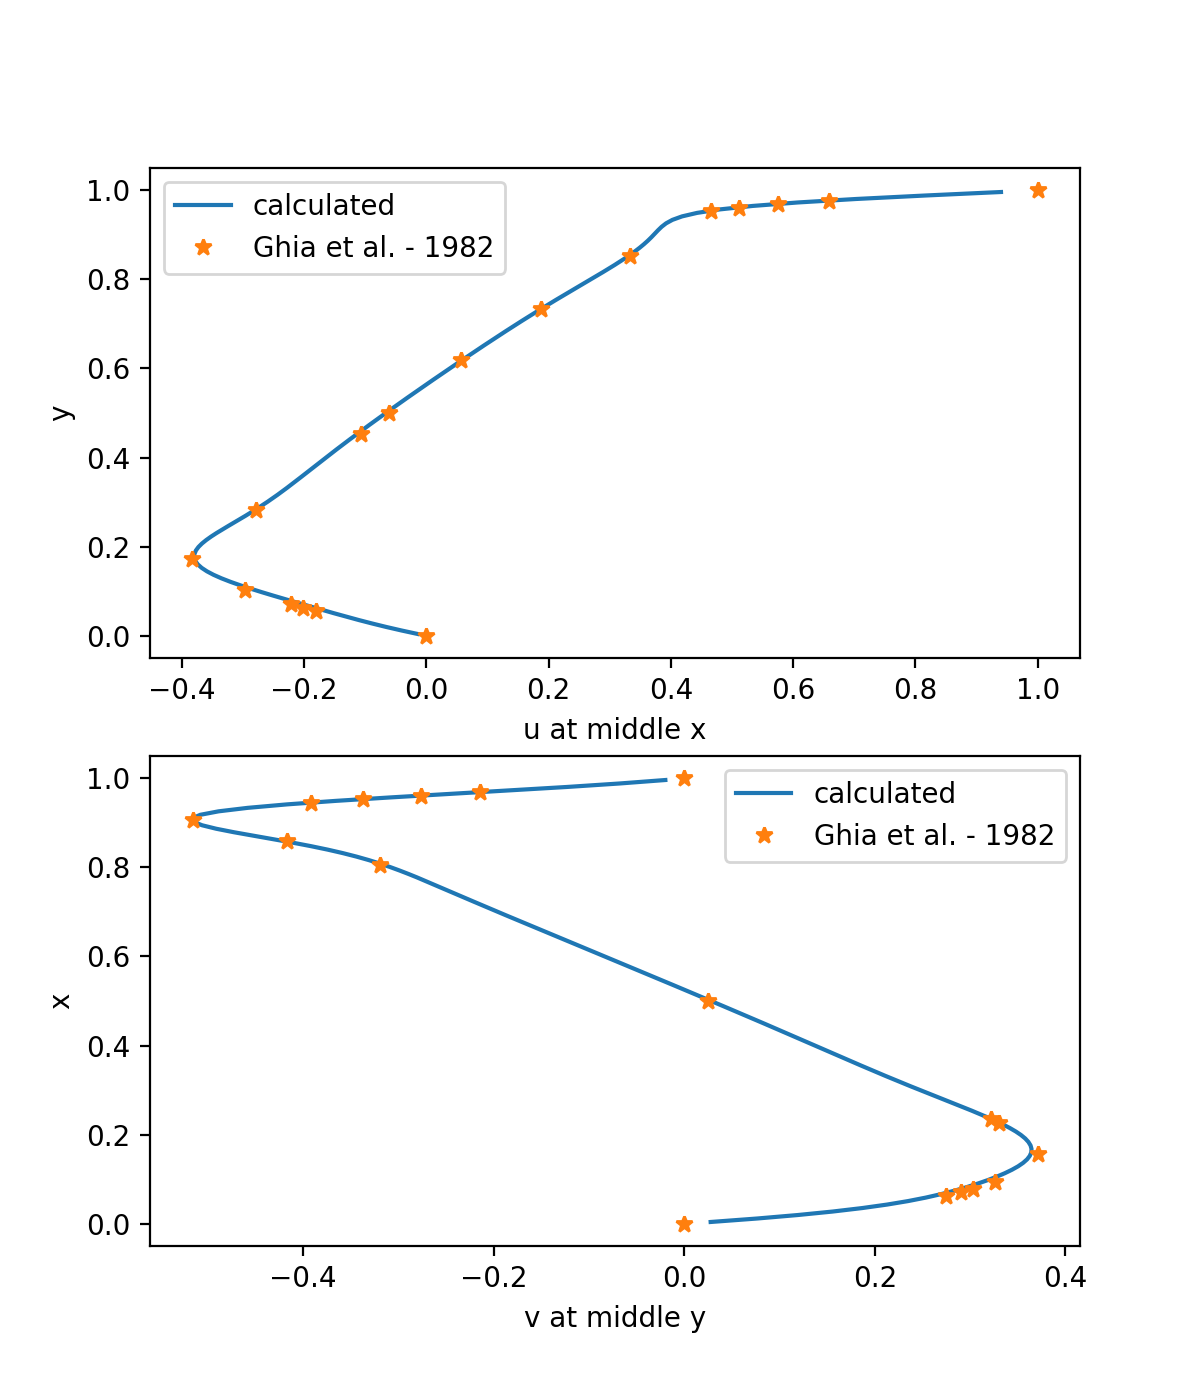

In [7]:
plot_lcd_contour(vel0,xc,yc,interval=10)

plot_lcd_compare(vel0,xc,yc,Re=1000,legend='calculated')